In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import sqlalchemy as db
import plotly.express as px
import csv

# Introduction
Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

# Define the target questions

# Data preparation

In [2]:
df_list = []
with open("HomeCredit_columns_description.csv", 'r',errors='ignore') as file:
    reader = csv.reader(file)
    for row in reader:
        df_list.append(pd.DataFrame({'table_name':row[1],'col_name':row[2],\
                                     'description':row[3]},index=list('A')))
df_description = pd.concat(df_list,axis=0).reset_index()
df_description.drop(columns='index',inplace=True)

In [3]:
def view_description_columns(table,data=df_description,column=None):
    if column is not None:
        return data[(data['table_name']==table)&(df_description['col_name']==column)][['col_name','description']]
    else:
        return data[data['table_name']==table][['col_name','description']]
    

## Previsous Application `prev_applic` columns description

In [4]:
prev_applic = pd.read_csv('previous_application.csv')

In [5]:
prev_applic.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
prev_applic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   SK_ID_PREV                   1670214 non-null  int64  
 1   SK_ID_CURR                   1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE           1670214 non-null  object 
 3   AMT_ANNUITY                  1297979 non-null  float64
 4   AMT_APPLICATION              1670214 non-null  float64
 5   AMT_CREDIT                   1670213 non-null  float64
 6   AMT_DOWN_PAYMENT             774370 non-null   float64
 7   AMT_GOODS_PRICE              1284699 non-null  float64
 8   WEEKDAY_APPR_PROCESS_START   1670214 non-null  object 
 9   HOUR_APPR_PROCESS_START      1670214 non-null  int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  1670214 non-null  object 
 11  NFLAG_LAST_APPL_IN_DAY       1670214 non-null  int64  
 12  RATE_DOWN_PAYMENT            774370 non-nu

In [7]:
view_description_columns(table='previous_application.csv',data=df_description)

,col_name,description
174,SK_ID_PREV,ID of previous credit in Home credit related t...
175,SK_ID_CURR,ID of loan in our sample
176,NAME_CONTRACT_TYPE,"Contract product type (Cash loan, consumer loa..."
177,AMT_ANNUITY,Annuity of previous application
178,AMT_APPLICATION,For how much credit did client ask on the prev...
179,AMT_CREDIT,Final credit amount on the previous applicatio...
180,AMT_DOWN_PAYMENT,Down payment on the previous application
181,AMT_GOODS_PRICE,Goods price of good that client asked for (if ...
182,WEEKDAY_APPR_PROCESS_START,On which day of the week did the client apply ...
183,HOUR_APPR_PROCESS_START,Approximately at what day hour did the client ...


## Installments `installments` columns description

In [8]:
installments  = pd.read_csv('installments_payments.csv')
installments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [9]:
installments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   SK_ID_CURR              int64  
 2   NUM_INSTALMENT_VERSION  float64
 3   NUM_INSTALMENT_NUMBER   int64  
 4   DAYS_INSTALMENT         float64
 5   DAYS_ENTRY_PAYMENT      float64
 6   AMT_INSTALMENT          float64
 7   AMT_PAYMENT             float64
dtypes: float64(5), int64(3)
memory usage: 830.4 MB


In [10]:
view_description_columns(table='installments_payments.csv',data=df_description)

,col_name,description
212,SK_ID_PREV,ID of previous credit in Home credit related t...
213,SK_ID_CURR,ID of loan in our sample
214,NUM_INSTALMENT_VERSION,Version of installment calendar (0 is for cred...
215,NUM_INSTALMENT_NUMBER,On which installment we observe payment
216,DAYS_INSTALMENT,When the installment of previous credit was su...
217,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...
218,AMT_INSTALMENT,What was the prescribed installment amount of ...
219,AMT_PAYMENT,What the client actually paid on previous cred...


## POS_CASH_Balance ` pos_cash_bal` column descriptions

In [11]:
pos_cash_bal = pd.read_csv('POS_CASH_balance.csv')
pos_cash_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [12]:
pos_cash_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   SK_ID_PREV             int64  
 1   SK_ID_CURR             int64  
 2   MONTHS_BALANCE         int64  
 3   CNT_INSTALMENT         float64
 4   CNT_INSTALMENT_FUTURE  float64
 5   NAME_CONTRACT_STATUS   object 
 6   SK_DPD                 int64  
 7   SK_DPD_DEF             int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 610.4+ MB


In [13]:
view_description_columns(table='POS_CASH_balance.csv',data=df_description)

,col_name,description
143,SK_ID_PREV,ID of previous credit in Home Credit related t...
144,SK_ID_CURR,ID of loan in our sample
145,MONTHS_BALANCE,Month of balance relative to application date ...
146,CNT_INSTALMENT,Term of previous credit (can change over time)
147,CNT_INSTALMENT_FUTURE,Installments left to pay on the previous credit
148,NAME_CONTRACT_STATUS,Contract status during the month
149,SK_DPD,DPD (days past due) during the month of previo...
150,SK_DPD_DEF,DPD during the month with tolerance (debts wit...


## Credit card balance `credit_card_bal` columns description

In [14]:
credit_card_bal = pd.read_csv('credit_card_balance.csv')
credit_card_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [15]:
credit_card_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   SK_ID_PREV                  int64  
 1   SK_ID_CURR                  int64  
 2   MONTHS_BALANCE              int64  
 3   AMT_BALANCE                 float64
 4   AMT_CREDIT_LIMIT_ACTUAL     int64  
 5   AMT_DRAWINGS_ATM_CURRENT    float64
 6   AMT_DRAWINGS_CURRENT        float64
 7   AMT_DRAWINGS_OTHER_CURRENT  float64
 8   AMT_DRAWINGS_POS_CURRENT    float64
 9   AMT_INST_MIN_REGULARITY     float64
 10  AMT_PAYMENT_CURRENT         float64
 11  AMT_PAYMENT_TOTAL_CURRENT   float64
 12  AMT_RECEIVABLE_PRINCIPAL    float64
 13  AMT_RECIVABLE               float64
 14  AMT_TOTAL_RECEIVABLE        float64
 15  CNT_DRAWINGS_ATM_CURRENT    float64
 16  CNT_DRAWINGS_CURRENT        int64  
 17  CNT_DRAWINGS_OTHER_CURRENT  float64
 18  CNT_DRAWINGS_POS_CURRENT    float64
 19  CNT_INSTALMENT_MATURE

In [16]:
view_description_columns('credit_card_balance.csv',data=df_description)

,col_name,description
151,SK_ID_PREV,ID of previous credit in Home credit related t...
152,SK_ID_CURR,ID of loan in our sample
153,MONTHS_BALANCE,Month of balance relative to application date ...
154,AMT_BALANCE,Balance during the month of previous credit
155,AMT_CREDIT_LIMIT_ACTUAL,Credit card limit during the month of the prev...
156,AMT_DRAWINGS_ATM_CURRENT,Amount drawing at ATM during the month of the ...
157,AMT_DRAWINGS_CURRENT,Amount drawing during the month of the previou...
158,AMT_DRAWINGS_OTHER_CURRENT,Amount of other drawings during the month of t...
159,AMT_DRAWINGS_POS_CURRENT,Amount drawing or buying goods during the mont...
160,AMT_INST_MIN_REGULARITY,Minimal installment for this month of the prev...


## Bureau `bureau` columns description
- All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
- For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [17]:
bureau = pd.read_csv('bureau.csv')
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [18]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_CURR              int64  
 1   SK_ID_BUREAU            int64  
 2   CREDIT_ACTIVE           object 
 3   CREDIT_CURRENCY         object 
 4   DAYS_CREDIT             int64  
 5   CREDIT_DAY_OVERDUE      int64  
 6   DAYS_CREDIT_ENDDATE     float64
 7   DAYS_ENDDATE_FACT       float64
 8   AMT_CREDIT_MAX_OVERDUE  float64
 9   CNT_CREDIT_PROLONG      int64  
 10  AMT_CREDIT_SUM          float64
 11  AMT_CREDIT_SUM_DEBT     float64
 12  AMT_CREDIT_SUM_LIMIT    float64
 13  AMT_CREDIT_SUM_OVERDUE  float64
 14  CREDIT_TYPE             object 
 15  DAYS_CREDIT_UPDATE      int64  
 16  AMT_ANNUITY             float64
dtypes: float64(8), int64(6), object(3)
memory usage: 222.6+ MB


In [19]:
view_description_columns('bureau.csv',data=df_description)

,col_name,description
123,SK_ID_CURR,ID of loan in our sample - one loan in our sam...
124,SK_BUREAU_ID,Recoded ID of previous Credit Bureau credit re...
125,CREDIT_ACTIVE,Status of the Credit Bureau (CB) reported credits
126,CREDIT_CURRENCY,Recoded currency of the Credit Bureau credit
127,DAYS_CREDIT,How many days before current application did c...
128,CREDIT_DAY_OVERDUE,Number of days past due on CB credit at the ti...
129,DAYS_CREDIT_ENDDATE,Remaining duration of CB credit (in days) at t...
130,DAYS_ENDDATE_FACT,Days since CB credit ended at the time of appl...
131,AMT_CREDIT_MAX_OVERDUE,Maximal amount overdue on the Credit Bureau cr...
132,CNT_CREDIT_PROLONG,How many times was the Credit Bureau credit pr...


## Bureau balance `bureau_applic` columns description
- Monthly balances of previous credits in Credit Bureau.
- This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [20]:
bureau_applic = pd.read_csv('bureau_balance.csv')
bureau_applic.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [21]:
bureau_applic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   SK_ID_BUREAU    int64 
 1   MONTHS_BALANCE  int64 
 2   STATUS          object
dtypes: int64(2), object(1)
memory usage: 624.8+ MB


In [22]:
view_description_columns('bureau_balance.csv',data=df_description)

,col_name,description
140,SK_BUREAU_ID,Recoded ID of Credit Bureau credit (unique cod...
141,MONTHS_BALANCE,Month of balance relative to application date ...
142,STATUS,Status of Credit Bureau loan during the month ...


## Train data `train_data` columns descriptiions

In [23]:
train_data = pd.read_csv('application_train.csv')
train_data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [25]:
test_data = pd.read_csv('application_test.csv')

In [26]:
test_data

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


# Data Completeness Check

## Missing value check

In [27]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
                                                               "There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values.")
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

### Previous Application Missing value check

In [28]:
missing_values_table(prev_applic)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIMARY,1664263,99.6
RATE_INTEREST_PRIVILEGED,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_LAST_DUE_1ST_VERSION,673065,40.3
DAYS_LAST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3


### Installments Missing value check

In [29]:
missing_values_table(installments)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


### POS_CASH_Balance Missing value check

In [30]:
missing_values_table(pos_cash_bal)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


### Credit card balance Missing value check

In [31]:
missing_values_table(credit_card_bal)

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


### Bureau Missing value check

In [32]:
missing_values_table(bureau)

Your selected dataframe has 17 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
AMT_ANNUITY,1226791,71.5
AMT_CREDIT_MAX_OVERDUE,1124488,65.5
DAYS_ENDDATE_FACT,633653,36.9
AMT_CREDIT_SUM_LIMIT,591780,34.5
AMT_CREDIT_SUM_DEBT,257669,15.0
DAYS_CREDIT_ENDDATE,105553,6.1
AMT_CREDIT_SUM,13,0.0


### Bureau balance Missing value check

In [33]:
missing_values_table(bureau_applic)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


### Train data Missing value check

In [34]:
missing_values_table(train_data)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
...,...,...
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
AMT_ANNUITY,12,0.0
CNT_FAM_MEMBERS,2,0.0


# Exploratory Data Analysis and Data Processing

## application_{train|test}.csv

### Distribution of target column in training dataset

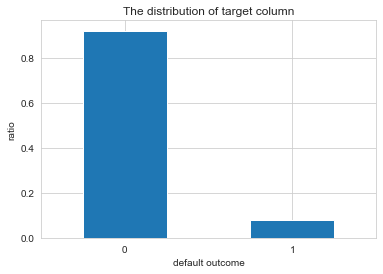

In [35]:
plt.figure()
train_data['TARGET'].value_counts(normalize = True).plot(kind = 'bar')
plt.title('The distribution of target column')
plt.xlabel('default outcome')
plt.ylabel('ratio')
plt.xticks(rotation = 0)
plt.show()

## bureau.csv

### Credit type and amount of total credit distribution

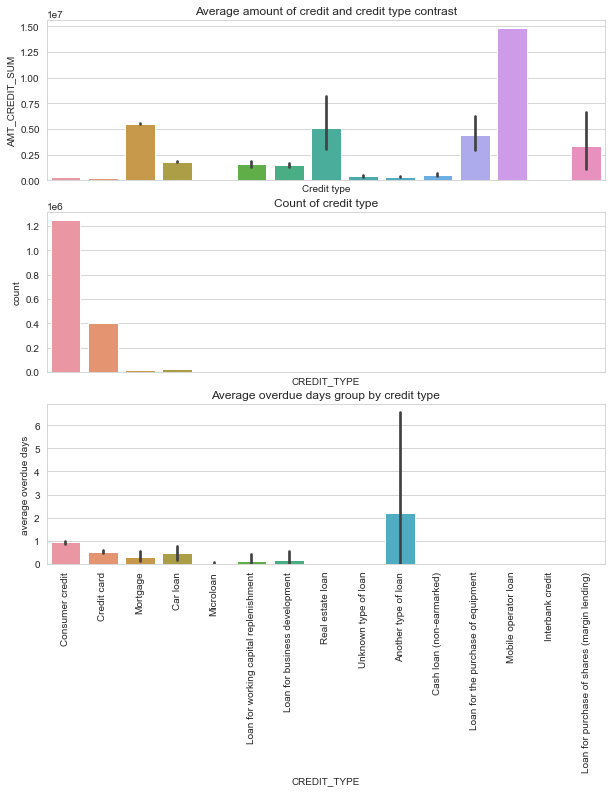

In [36]:
fig,(ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1,sharex=True,figsize= (10,10))
plt.subplot(3,1,1)
sns.barplot(data = bureau,x = 'CREDIT_TYPE',y='AMT_CREDIT_SUM',estimator=np.mean,ax = ax1)
plt.xticks(rotation = 90)
plt.xlabel('Credit type')
plt.title('Average amount of credit and credit type contrast')
plt.subplot(3,1,2)
sns.countplot(data= bureau, x='CREDIT_TYPE',ax = ax2)
plt.xticks(rotation = 90)
plt.title('Count of credit type')
plt.subplot(3,1,3)
sns.barplot(data= bureau, x = 'CREDIT_TYPE', y = 'CREDIT_DAY_OVERDUE', estimator=np.mean,ax = ax3)
plt.xticks(rotation = 90)
plt.title('Average overdue days group by credit type')
plt.ylabel('average overdue days')
plt.show()


### Overdue Amount classified by currency

<Figure size 432x288 with 0 Axes>

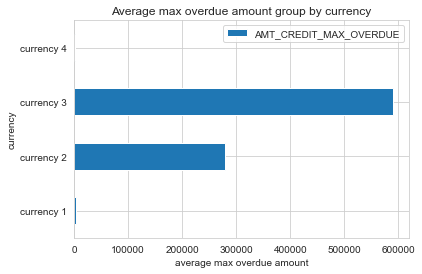

In [37]:
plt.figure()
bureau[['CREDIT_CURRENCY','AMT_CREDIT_MAX_OVERDUE']].groupby('CREDIT_CURRENCY').agg(np.mean).plot(kind='barh')
plt.xlabel('average max overdue amount')
plt.ylabel('currency')
plt.title('Average max overdue amount group by currency')
plt.show()

## previous_application,csv

### Amount customers previously requested VS. Amount customers finally got approved

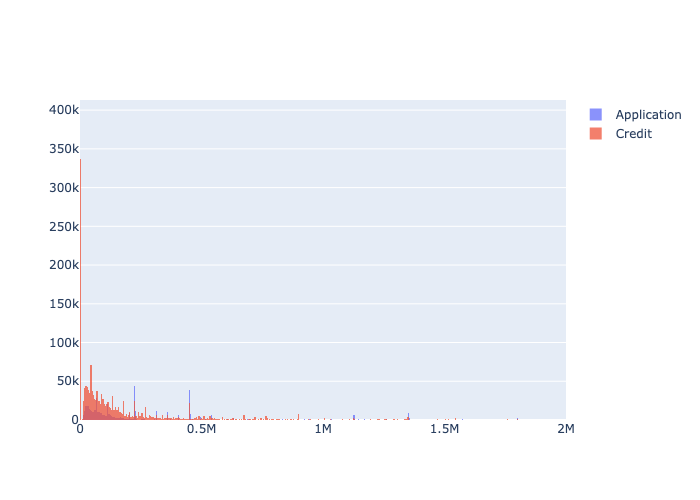

In [43]:
import plotly.graph_objects as go
x0 =prev_applic['AMT_APPLICATION']
x1 =prev_applic['AMT_CREDIT']
fig = go.Figure()
fig.add_trace(go.Histogram(x=x0,name='Application'))
fig.add_trace(go.Histogram(x=x1,name='Credit'))
fig.update_layout(barmode='overlay')
fig.update_traces(opacity = 0.75)
fig.update_xaxes(range=[0,2000000])
fig.show('png')

## Average goods price

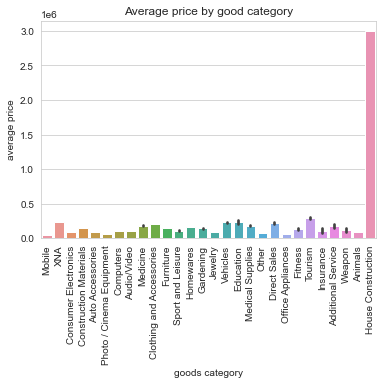

In [51]:
sns.barplot(data= prev_applic,x='NAME_GOODS_CATEGORY',y = 'AMT_APPLICATION', estimator= np.mean)
plt.xticks(rotation = 90)
plt.xlabel('goods category')
plt.ylabel('average price')
plt.title('Average price by good category')
plt.show()

## POS_CASH_balance.csv

### Contract status and overdue days in the current month

<AxesSubplot:xlabel='NAME_CONTRACT_STATUS'>

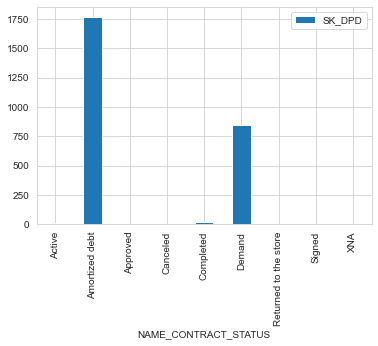

In [62]:
pos_cash_bal[['NAME_CONTRACT_STATUS','SK_DPD']].groupby('NAME_CONTRACT_STATUS').agg(np.mean).plot(kind='bar')
plt.show()

## credit_card_balance.csv

### Overdue days of monthly payments and current amount of total payment

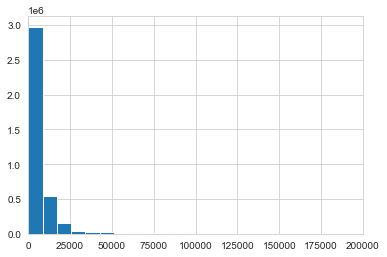

In [75]:

plt.hist(credit_card_bal['AMT_PAYMENT_TOTAL_CURRENT'],bins=500)
plt.xlim([0,200000])
plt.show()

## installments.csv

### Amount of installments distribution

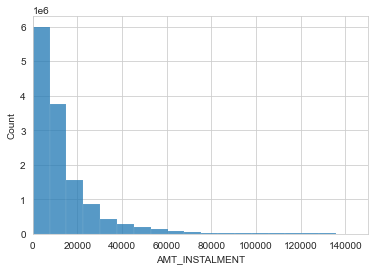

In [60]:
sns.histplot(data= installments, x='AMT_INSTALMENT', bins= 500)
plt.xlim( [0,150000])
plt.show()

# Model Construction